# Natural Language Processing: Sentiment Analysis of Amazon Reviews
**Group 58**

**Team:** Federico Cimini (CIS 5190), Liang-Yun Cheng (CIS 5190), Samuel Thudium (CIS 5190)

**Project Mentor TA:** David Yan

# 1: Imports

In [63]:
# Imports required libraries

# for data wrangling
import numpy as np
import pandas as pd
import re, datetime
import string

# for NLP / sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud

# for model building
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import metrics
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

# for exporting cleaned data
import os
from os.path import join
from joblib import dump, load

#unused: 
from sklearn.svm import SVR



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# 2: Data Loading

In [64]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [65]:
dir = '/content/drive/Shareddrives/CIS5190-FoodReviews/'

In [ ]:
reviews_df = pd.read_csv(join(dir, 'RawData/Reviews.csv.zip'))

In [ ]:
reviews_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
print(reviews_df.shape)

(568454, 10)


# 3.1: Data Cleaning (Without Stopwords)

Data cleaning steps including, droping rows with missing data, dropping duplicates, and text preparation ( removal of hyperlinks, digits, stopwords and performing lemmatization). 

### 3.1.1: Remove records with NULL values


In [ ]:
reviews_cleaned = reviews_df[['Text', 'Summary', 'Score']].dropna(axis=0)

### 3.1.2: Text Cleaning



In [ ]:
def clean_content(text):
    #print(text)
    # remove hyperlink
    text = re.sub(r'(https|http)\S+',"", text)
    
    # remove digits
    text = re.sub(r'\d+', "", text)
    
    # seperate text among apostrophes
    text = re.sub(r'\'', " ", text)
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', "", text)
           
    # convert to all lowercase
    text = text.lower()
    
    # tokenize and remove punctuation
    tokens = nltk.word_tokenize(text)
    
    # remove stopwords
    stop_words = set(stopwords.words('english'))
    cleaned_token = [i for i in tokens if i not in stop_words]
    
    # Normalize words >> convert words into root form
    lemmatizer = nltk.WordNetLemmatizer()
    norm_token = [lemmatizer.lemmatize(i, pos='v') for i in cleaned_token]
    
    # concat all words back together 
    result =' '.join(norm_token)
    return result

In [ ]:
reviews_cleaned['cleaned_text'] = reviews_cleaned['Text'].apply(clean_content)
reviews_cleaned['cleaned_summary'] = reviews_cleaned['Summary'].apply(clean_content)

### 3.1.3: Drop duplicates and NULL's
Some rows might end up with NULL values after tokenization

In [ ]:
reviews_cleaned.dropna(axis=0, inplace=True)
reviews_cleaned.drop_duplicates(inplace=True)

## 3.1.4: Score classification:
1 for positive (score is 4-5) or -1 for negative (score is 1-3)

In [ ]:
## Separete positive and negaitve reviews
reviews_cleaned['Score_class'] = reviews_cleaned['Score'].apply(lambda x: 1 if x > 3 else -1)

## 3.1.5: Export Cleaned Data

In [ ]:
# Assert no NAs present
assert(reviews_cleaned.isna().sum().sum() == 0)

In [ ]:
reviews_cleaned.to_csv(join(dir, 'CleanedData/Reviews_cleanText_noSW.csv'), index=False, header=True)

# 3.2: Data Cleaning (With Stopwords)

Data cleaning steps including, droping rows with missing data, dropping duplicates, and text preparation ( removal of hyperlinks, digits, and performing lemmatization). In this section, however, we do not remove stopwords.

### 3.2.1: Remove records with NULL values


In [ ]:
reviews_cleaned_sw = reviews_df[['Text', 'Summary', 'Score']].dropna(axis=0)
reviews_cleaned_sw.head()

,Text,Summary,Score
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1
2,This is a confection that has been around a fe...,"""Delight"" says it all",4
3,If you are looking for the secret ingredient i...,Cough Medicine,2
4,Great taffy at a great price. There was a wid...,Great taffy,5


### 3.2.2: Text Cleaning



In [ ]:
def clean_content_sw(text):
    #print(text)
    # remove hyperlink
    text = re.sub(r'(https|http)\S+',"", text)
    
    # remove digits
    text = re.sub(r'\d+', "", text)
    
    # seperate text among apostrophes
    text = re.sub(r'\'', " ", text)
    
    # remove punctuation
    text = re.sub(r'[^\w\s]', "", text)
           
    # convert to all lowercase
    text = text.lower()
    
    # tokenize and remove punctuation
    tokens = nltk.word_tokenize(text)
    
    # remove stopwords
    # stop_words = set(stopwords.words('english'))
    #cleaned_token = [i for i in tokens if i not in stop_words]
    cleaned_token = [i for i in tokens]

    # Normalize words >> convert words into root form
    lemmatizer = nltk.WordNetLemmatizer()
    norm_token = [lemmatizer.lemmatize(i, pos='v') for i in cleaned_token]
    
    # concat all words back together 
    result =' '.join(norm_token)
    return result

In [ ]:
reviews_cleaned_sw['cleaned_text'] = reviews_cleaned_sw['Text'].apply(clean_content_sw)
reviews_cleaned_sw['cleaned_summary'] = reviews_cleaned_sw['Summary'].apply(clean_content_sw)

### 3.2.3: Drop duplicates and NULL's
Some rows might end up with NULL values after tokenization

In [ ]:
reviews_cleaned_sw.dropna(axis=0, inplace=True)
reviews_cleaned_sw.drop_duplicates(inplace=True)

## 3.2.4: Score classification:
1 for positive (score is 4-5) or -1 for negative (score is 1-3)

In [ ]:
## Separete positive and negaitve reviews
reviews_cleaned_sw['Score_class'] = reviews_cleaned_sw['Score'].apply(lambda x: 1 if x > 3 else -1)

## 3.2.5 Export Cleaned Data

In [ ]:
# Assert no NAs present
assert(reviews_cleaned_sw.isna().sum().sum() == 0)

In [ ]:
from os.path import join
reviews_cleaned_sw.to_csv(join(dir, 'CleanedData/Reviews_cleanText_sw.csv'), index=False, header=True)

# 4.1: EDA (Without Stopwords)

## 4.1.1: Word Clouds

In [66]:
reviews_df = pd.read_csv(join(dir, 'CleanedData/Reviews_cleanText_noSW.csv'))
reviews_df.head()

,Text,Summary,Score,cleaned_text,cleaned_summary,Score_class
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,buy several vitality can dog food products fin...,good quality dog food,1
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1,product arrive label jumbo salt peanutsthe pea...,advertise,-1
2,This is a confection that has been around a fe...,"""Delight"" says it all",4,confection around centuries light pillowy citr...,delight say,1
3,If you are looking for the secret ingredient i...,Cough Medicine,2,look secret ingredient robitussin believe find...,cough medicine,-1
4,Great taffy at a great price. There was a wid...,Great taffy,5,great taffy great price wide assortment yummy ...,great taffy,1


In [68]:
reviews_df.dropna(inplace=True)

In [67]:
## All Reviews

corpus = reviews_df['cleaned_text'].to_list()
corpus_flatten = [w for ls in corpus for w in ls.split()]
token_counter = Counter(corpus_flatten)
plt.figsize = (15,6)
wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate_from_frequencies(token_counter)
plt.imshow(wordcloud) # show wordcloud
plt.axis('off') # to hide x and y axes
plt.title("Word cloud of All Reviews", size=16, fontweight="bold")
plt.show()

AttributeError: ignored

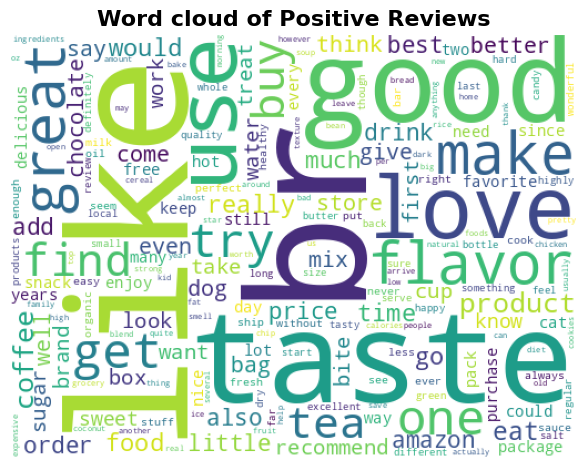

In [70]:
# Positive Words
corpus_pos = reviews_df[reviews_df['Score_class'] == 1]['cleaned_text'].to_list()
corpus_flatten_pos = [w for ls in corpus_pos for w in ls.split()]
token_counter_pos = Counter(corpus_flatten_pos)
wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate_from_frequencies(token_counter_pos)
plt.imshow(wordcloud) # show wordcloud
plt.axis('off') # to hide x and y axes
plt.title("Word cloud of Positive Reviews", size=16, fontweight="bold")
plt.tight_layout()
plt.savefig(join(dir, 'Plots/WC_positive.pdf'), dpi=400)

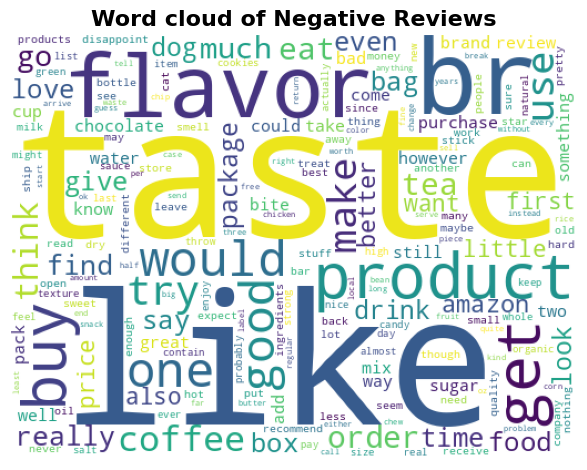

In [72]:
# Negative Words
corpus_neg = reviews_df[reviews_df['Score_class'] == -1]['cleaned_text'].to_list()
corpus_flatten_neg = [w for ls in corpus_neg for w in ls.split()]
token_counter_neg = Counter(corpus_flatten_neg)
wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate_from_frequencies(token_counter_neg)
plt.imshow(wordcloud) # show wordcloud
plt.axis('off') # to hide x and y axes
plt.title("Word cloud of Negative Reviews", size=16, fontweight="bold")
plt.tight_layout()
plt.savefig(join(dir, 'Plots/WC_negative.pdf'), dpi=400)

# 4.2: EDA (With Stopwords)

## 4.2.1: Word Clouds

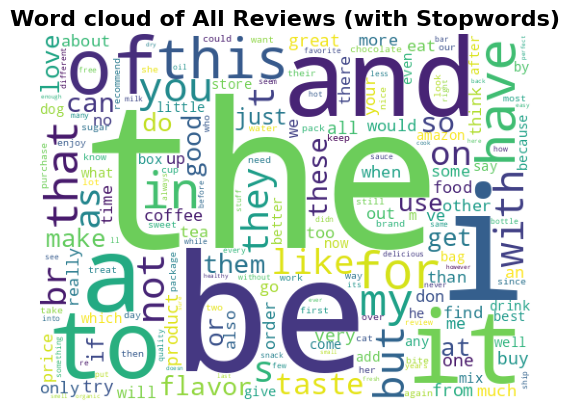

In [ ]:
## All Reviews

corpus = reviews_cleaned_sw['cleaned_text'].to_list()
corpus_flatten = [w for ls in corpus for w in ls.split()]
token_counter = Counter(corpus_flatten)
plt.figsize = (15,6)
wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate_from_frequencies(token_counter)
plt.imshow(wordcloud) # show wordcloud
plt.axis('off') # to hide x and y axes
plt.title("Word cloud of All Reviews (with Stopwords)", size=16, fontweight="bold")
plt.tight_layout()
plt.savefig(join(dir, 'Plots/pooled_scores_distrib.pdf'), dpi=400)

Text(0.5, 1.0, 'Word cloud of Positive Reviews (with Stopwords)')

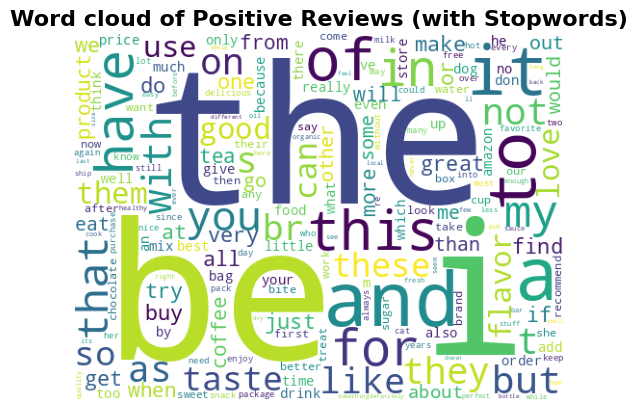

In [ ]:
# Positive Words
corpus_pos = reviews_cleaned_sw[reviews_cleaned_sw['Score_class'] == 1]['cleaned_text'].to_list()
# corpus_pos = reviews_cleaned_sw['cleaned_text'][reviews_cleaned_sw['Score_Encode'] == 1].to_list()
corpus_flatten_pos = [w for ls in corpus_pos for w in ls.split()]
token_counter_pos = Counter(corpus_flatten_pos)
wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate_from_frequencies(token_counter_pos)
plt.imshow(wordcloud) # show wordcloud
plt.axis('off') # to hide x and y axes
plt.title("Word cloud of Positive Reviews (with Stopwords)", size=16, fontweight="bold")

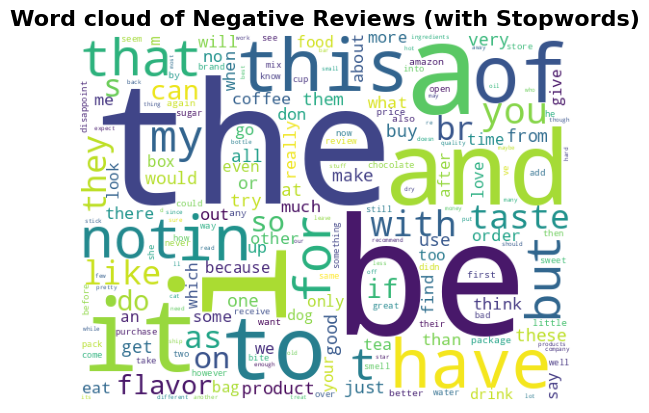

In [ ]:
# Negative Words
corpus_neg = reviews_cleaned_sw[reviews_cleaned_sw['Score_class'] == -1]['cleaned_text'].to_list()
# corpus_neg = reviews_df_cleaned['cleaned_text'][reviews_df_cleaned['Score_Encode'] == -1].to_list()
corpus_flatten_neg = [w for ls in corpus_neg for w in ls.split()]
token_counter_neg = Counter(corpus_flatten_neg)
wordcloud = WordCloud (
                      background_color = 'white',
                      width = 512,
                      height = 384
                          ).generate_from_frequencies(token_counter_neg)
plt.imshow(wordcloud) # show wordcloud
plt.axis('off') # to hide x and y axes
plt.title("Word cloud of Negative Reviews (with Stopwords)", size=16, fontweight="bold")
plt.show()

# 4.3 Basic EDA on label distribution

In [49]:
raw_scores = reviews_df['Score'].value_counts().sort_index()

In [ ]:
raw_scores

1     36505
2     20845
3     29842
4     56207
5    251604
Name: Score, dtype: int64

In [ ]:
pooled_scores = reviews_df['Score_class'].value_counts().sort_index()

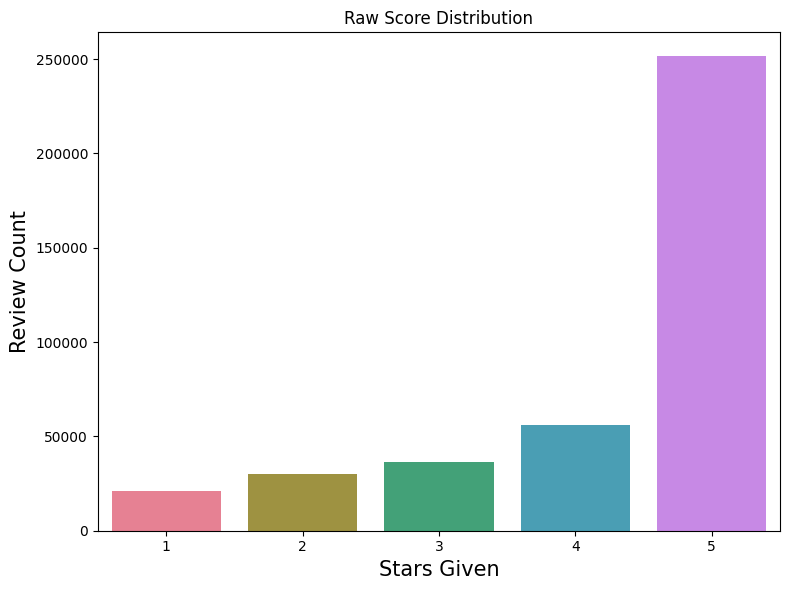

In [62]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x = raw_scores.index, y = raw_scores.values, data = raw_scores, dodge = True, palette = 'husl', errorbar=None)
ax.set_xticklabels([1, 2, 3, 4, 5])
plt.xlabel("Stars Given", fontsize=15)
plt.ylabel("Review Count", fontsize=15)
plt.title("Raw Score Distribution")
plt.tight_layout()
plt.savefig(join(dir, 'Plots/raw_scores_distrib.pdf'), dpi=400)

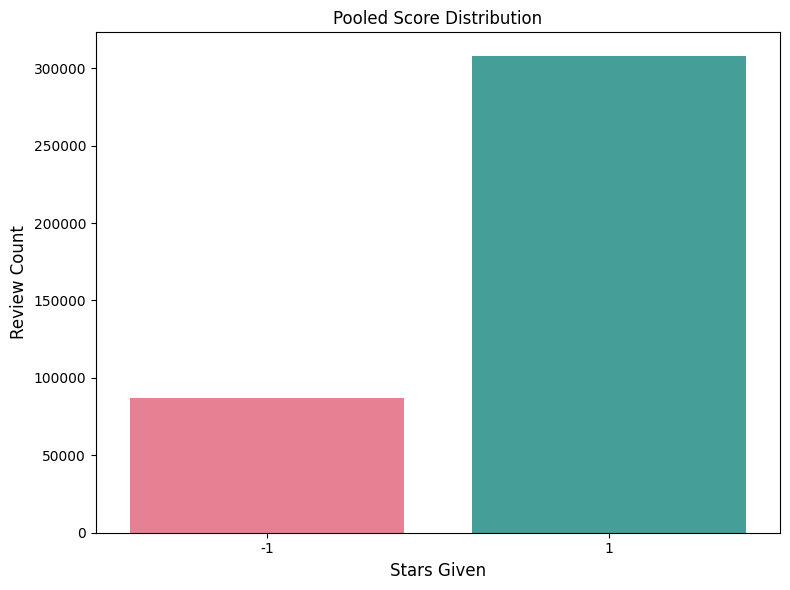

In [61]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x = pooled_scores.index, y = pooled_scores.values, data = pooled_scores, dodge = True, palette = 'husl', errorbar=None)
ax.set_xticklabels([-1, 1])
plt.xlabel("Stars Given", fontsize=12)
plt.ylabel("Review Count", fontsize=12)
plt.title("Pooled Score Distribution")
plt.tight_layout()
plt.savefig(join(dir, 'Plots/pooled_scores_distrib.pdf'), dpi=400)

# 4.4 Average length of review text and summaries

In [52]:
reviews_df = pd.read_csv(join(dir, 'CleanedData/Reviews_cleanText_noSW.csv'))
reviews_df.head()

,Text,Summary,Score,cleaned_text,cleaned_summary,Score_class
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,buy several vitality can dog food products fin...,good quality dog food,1
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1,product arrive label jumbo salt peanutsthe pea...,advertise,-1
2,This is a confection that has been around a fe...,"""Delight"" says it all",4,confection around centuries light pillowy citr...,delight say,1
3,If you are looking for the secret ingredient i...,Cough Medicine,2,look secret ingredient robitussin believe find...,cough medicine,-1
4,Great taffy at a great price. There was a wid...,Great taffy,5,great taffy great price wide assortment yummy ...,great taffy,1


In [53]:
reviews_df.columns

Index(['Text', 'Summary', 'Score', 'cleaned_text', 'cleaned_summary',
       'Score_class'],
      dtype='object')

In [55]:
reviews_df.dropna(inplace=True)

In [58]:
reviews_df['cleaned_text'].apply(lambda x : len(x.split())).agg(['mean', 'min', 'max', 'std', 'median'])

mean        39.563190
min          1.000000
max       1951.000000
std         39.807908
median      28.000000
Name: cleaned_text, dtype: float64

In [60]:
reviews_df['cleaned_summary'].apply(lambda x : len(x.split())).agg(['mean', 'min', 'max', 'std', 'median'])

mean       2.834476
min        1.000000
max       24.000000
std        1.547522
median     2.000000
Name: cleaned_summary, dtype: float64

# 5: Define Evaluation Metrics And Results output table

In [ ]:
def model_eval(actual, pred):
  ''' Take in two series of pred and actual and calculate a variety of evaluation metrics'''
  auc = metrics.roc_auc_score(actual, pred)
  acc = metrics.accuracy_score(actual, pred)
  f1 = metrics.f1_score(actual, pred)
  confusion_matrix_df = confusion_matrix(actual, pred)
  print(f'AUC Score: {auc}')
  print(f'Accuracy Score: {acc}')
  print(f'F1 Score: {f1}')
  print(confusion_matrix_df)
  return auc, acc, f1, confusion_matrix_df

In [ ]:
def add_model_scores_to_results(file_path, model_name:str, balanced:int, with_sw:int,
                                ROC_AUC, accuracy, f1, cm:np.ndarray, first_entry=False):
  results_df = pd.DataFrame(columns=['Timestamp', 'model_name', 'balanced', 
                                     'with_sw', 'ROC_AUC', 'accuracy', 'F1_score', 'cm'])
  results_df.loc[0] = [pd.Timestamp.now() , model_name, balanced, with_sw, ROC_AUC, accuracy, f1, cm.ravel()]

  results_df.to_csv(path_or_buf=file_path, mode='a', header=first_entry, index=False)

  print(f'{model_name} saved successfully!')

# 6: Baseline models

In [4]:
reviews_df = pd.read_csv(join(dir, 'CleanedData/Reviews_cleanText_noSW.csv'))
reviews_df.head()

,Text,Summary,Score,cleaned_text,cleaned_summary,Score_class
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,buy several vitality can dog food products fin...,good quality dog food,1
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1,product arrive label jumbo salt peanutsthe pea...,advertise,-1
2,This is a confection that has been around a fe...,"""Delight"" says it all",4,confection around centuries light pillowy citr...,delight say,1
3,If you are looking for the secret ingredient i...,Cough Medicine,2,look secret ingredient robitussin believe find...,cough medicine,-1
4,Great taffy at a great price. There was a wid...,Great taffy,5,great taffy great price wide assortment yummy ...,great taffy,1


In [10]:
raw_scores = reviews_df['Score'].value_counts().sort_index()

In [11]:
raw_scores

1     36505
2     20845
3     29842
4     56207
5    251604
Name: Score, dtype: int64

In [12]:
pooled_scores = reviews_df['Score_class'].value_counts().sort_index()

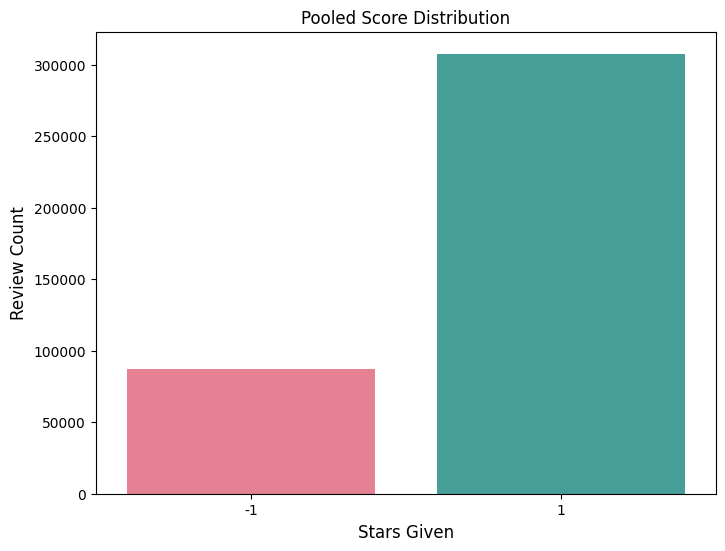

In [48]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x = raw_scores.index, y = raw_scores.values, data = raw_scores, dodge = True, palette = 'husl', errorbar=None)
ax.set_xticklabels([1, 2, 3, 4, 5])
plt.xlabel("Stars Given", fontsize=12)
plt.ylabel("Review Count", fontsize=12)
plt.title("Raw Score Distribution")
plt.show()

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = sns.barplot(x = pooled_scores.index, y = pooled_scores.values, data = pooled_scores, dodge = True, palette = 'husl', errorbar=None)
ax.set_xticklabels([-1, 1])
plt.xlabel("Stars Given", fontsize=12)
plt.ylabel("Review Count", fontsize=12)
plt.title("Pooled Score Distribution")
plt.show()

In [ ]:
reviews_sw_df = pd.read_csv('/content/drive/Shareddrives/CIS5190-FoodReviews/CleanedData/Reviews_cleanText_sw.csv')
reviews_sw_df.head()

,Text,Summary,Score,cleaned_text,cleaned_summary,Score_class
0,I have bought several of the Vitality canned d...,Good Quality Dog Food,5,i have buy several of the vitality can dog foo...,good quality dog food,1
1,Product arrived labeled as Jumbo Salted Peanut...,Not as Advertised,1,product arrive label as jumbo salt peanutsthe ...,not as advertise,-1
2,This is a confection that has been around a fe...,"""Delight"" says it all",4,this be a confection that have be around a few...,delight say it all,1
3,If you are looking for the secret ingredient i...,Cough Medicine,2,if you be look for the secret ingredient in ro...,cough medicine,-1
4,Great taffy at a great price. There was a wid...,Great taffy,5,great taffy at a great price there be a wide a...,great taffy,1


## 6.1: Baseline Model (Constant Prediction): Predict Majority Class

- This model predicts majority class of an imbalanced dataset. Also, it does not consider

In [ ]:
freq = reviews_df['Score_class'].value_counts().reset_index()
majority_label = freq['index'].to_list()[0]

# predict majority class
reviews_df["base_pred"] = majority_label

In [ ]:
reviews_df['Score_class'].value_counts()

 1    307811
-1     87192
Name: Score_class, dtype: int64

In [ ]:
reviews_df["base_pred"].value_counts()

1    395003
Name: base_pred, dtype: int64

In [ ]:
maj_auc, maj_acc, maj_f1, maj_cm = model_eval(reviews_df["Score_class"], reviews_df["base_pred"])

AUC Score: 0.5
Accuracy Score: 0.7792624359814989
F1 Score: 0.8759387263201928
[[     0  87192]
 [     0 307811]]


In [ ]:
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Baseline_Majority',
                            balanced = 1, with_sw = 0,
                            ROC_AUC = maj_auc, accuracy = maj_acc, 
                            f1 = maj_f1, cm = maj_cm, first_entry=True)

Baseline_Majority saved successfully!


## 6.2: Advanced Baseline Model: TF-IDF and Logistic Regression

Our baseline model will be a TF-IDF word vectorization with logistic regression classification. This will be trained on the review text with stopwords REMOVED. Further, we have opted to train the baseline on a balanced dataset which we produce by undersampling the majority (positive) class.

### 6.2.1 Undersampled Data (balanced - w/o Stopwords)

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(reviews_df["cleaned_text"].array.reshape(-1, 1), reviews_df["Score_class"])

#train, test = train_test_split(cleaned_df.iloc[:10000,:], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

X_train = pd.Series(X_train[:,0]) 
X_test = pd.Series(X_test[:,0]) 

print("%d items in training data, %d in test data" % (len(X_train), len(X_test)))

139507 items in training data, 34877 in test data


In [ ]:
# Ensure no NAs
assert(X_train.isna().sum().sum() == 0)

In [ ]:

count_vect = CountVectorizer(min_df = 1, ngram_range = (1, 4))
count_vect = count_vect.fit(X_train)
X_train_counts = count_vect.transform(X_train)

tfidf_transformer = TfidfTransformer()
tfidf_transformer = tfidf_transformer.fit(X_train_counts)
X_train_tfidf = tfidf_transformer.transform(X_train_counts)

X_new_counts = count_vect.transform(X_test)
X_test_tfidf = tfidf_transformer.transform(X_new_counts)

#y_train = train["Score_class"]
#y_test = test["Score_class"]

prediction = dict()

In [ ]:
logreg = LogisticRegression()
logreg = logreg.fit(X_train_tfidf, y_train)
prediction['Logistic'] = logreg.predict(X_test_tfidf)

In [ ]:
log_auc, log_acc, log_f1, log_cm = model_eval(y_test, prediction["Logistic"])

AUC Score: 0.8450363163242005
Accuracy Score: 0.8450268084984374
F1 Score: 0.8455405366787644
[[14678  2794]
 [ 2611 14794]]


In [ ]:
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Baseline_Log_TFIDF',
                            balanced = 1, with_sw = 0,
                            ROC_AUC = log_auc, accuracy = log_acc, 
                            f1 = log_f1, cm = log_cm, first_entry=False)

Baseline_Log_TFIDF saved successfully!


In [ ]:
# Save CountVectorizer, TFIDF transformer, and logistic regression model to binary
dump(count_vect, join(dir, 'TrainedModelBinaries/Baseline_TFIDF_cntVectorizer.joblib'))
dump(tfidf_transformer, join(dir, 'TrainedModelBinaries/Baseline_TFIDF_transformer.joblib'))
dump(logreg, join(dir, 'TrainedModelBinaries/Baseline_TFIDF_logreg.joblib'))

['/content/drive/Shareddrives/CIS5190-FoodReviews/TrainedModelBinaries/Baseline_TFIDF_logreg.joblib']

### 6.2.2 Random Sample Data (unbalanced - w/o Stopwords)

In [ ]:
# random sample with original proportion
review_df_subset = reviews_df.sample(n = 180000, random_state = 42)
review_df_subset.dropna(inplace=True)
# split data into train, test
train, test = train_test_split(review_df_subset, test_size=0.3)


print("%d items in training data, %d in test data" % (len(train), len(test)))

125703 items in training data, 53874 in test data


In [ ]:
# Load the saved pretrained models
count_vect_pretrained = load(join(dir, 'TrainedModelBinaries/Baseline_TFIDF_cntVectorizer.joblib'))
tfidf_transformer_pretrained = load(join(dir, 'TrainedModelBinaries/Baseline_TFIDF_transformer.joblib'))
logreg_pretrained = load(join(dir, 'TrainedModelBinaries/Baseline_TFIDF_logreg.joblib'))

In [ ]:
# Apply the trained count vectorizer and tfidf transformer on unbalanced data
X_train_counts = count_vect.transform(test['cleaned_text'])
x_test_tfidf = tfidf_transformer.transform(X_train_counts)

In [ ]:
# Predict using the Logistic Regression model trained in 6.2.1
prediction['Log_TFIDF'] = logreg.predict(x_test_tfidf)

In [ ]:
log_auc, log_acc, log_f1, log_cm = model_eval(test['Score_class'], prediction["Log_TFIDF"])

AUC Score: 0.8917033878567695
Accuracy Score: 0.8786056353714222
F1 Score: 0.9178206127013646
[[10813  1004]
 [ 5536 36521]]


In [ ]:
# gather info on model result
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Log_TFIDF_unbalanced',
                            balanced = 0, with_sw = 0,
                            ROC_AUC = log_auc, accuracy = log_acc, 
                            f1 = log_f1, cm = log_cm, first_entry=False)

Log_TFIDF_unbalanced saved successfully!


### 6.2.3 Undersampled Data (balanced - w/ Stopwords)

In [ ]:
reviews_sw_df.dropna(inplace = True)

In [ ]:

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(reviews_sw_df["cleaned_text"].array.reshape(-1, 1), reviews_sw_df["Score_class"])

#train, test = train_test_split(cleaned_df.iloc[:10000,:], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

X_train = pd.Series(X_train[:,0]) 
X_test = pd.Series(X_test[:,0]) 

print("%d items in training data, %d in test data" % (len(X_train), len(X_test)))

139400 items in training data, 34850 in test data


In [ ]:
# Apply the trained count vectorizer and tfidf transformer on unbalanced data
X_train_counts = count_vect.transform(X_test)
x_test_tfidf = tfidf_transformer.transform(X_train_counts)


In [ ]:
# Predict using the logistic regression model trained in 6.2.1
prediction['Log_TFIDF_SW_balanced'] = logreg.predict(x_test_tfidf)

In [ ]:
sw_log_auc, sw_log_acc, sw_log_f1, sw_log_cm = model_eval(y_test, prediction["Log_TFIDF_SW_balanced"])

AUC Score: 0.8561400611992878
Accuracy Score: 0.8560975609756097
F1 Score: 0.8555878711089354
[[14979  2354]
 [ 2661 14856]]


In [ ]:
# gather info on model result
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Log_TFIDF_SW_balanced',
                            balanced = 1, with_sw = 1,
                            ROC_AUC = sw_log_auc, accuracy = sw_log_acc, 
                            f1 = sw_log_f1, cm = sw_log_cm, first_entry=False)


Log_TFIDF_SW_balanced saved successfully!


### 6.2.4 Random Sample Data (unbalanced - w/ Stopwords)

In [ ]:
# random sample with original proportion
review_df_sw_subset = reviews_sw_df.sample(n = 180000, random_state = 42)

# split data into train, test
train, test = train_test_split(review_df_sw_subset, test_size=0.2)

#X_train = pd.Series(X_train[:,0]) 
#X_test = pd.Series(X_test[:,0]) 

print("%d items in training data, %d in test data" % (len(train), len(test)))

144000 items in training data, 36000 in test data


In [ ]:
# Apply the trained count vectorizer and tfidf transformer on unbalanced data
X_train_counts = count_vect.transform(test['cleaned_text'])
x_test_tfidf = tfidf_transformer.transform(X_train_counts)


In [ ]:
# Predict using the logistic regression model trained in 6.2.1
prediction['Log_TFIDF_SW_unbalanced'] = logreg.predict(x_test_tfidf)

In [ ]:
sw_log_auc, sw_log_acc, sw_log_f1, sw_log_cm = model_eval(test['Score_class'], prediction["Log_TFIDF_SW_unbalanced"])

AUC Score: 0.8556818146963204
Accuracy Score: 0.8504444444444444
F1 Score: 0.8979839320903441
[[ 6920  1079]
 [ 4305 23696]]


In [ ]:
# gather info on model result
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Log_TFIDF_SW_unbalanced',
                            balanced = 0, with_sw = 1,
                            ROC_AUC = sw_log_auc, accuracy = sw_log_acc, 
                            f1 = sw_log_f1, cm = sw_log_cm, first_entry=False)


Log_TFIDF_SW_unbalanced saved successfully!


### 6.2.5 Undersampled Summary Text Data (balanced - w/o Stopwords)

In [ ]:
reviews_df.dropna(inplace=True)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(reviews_df['cleaned_summary'].array.reshape(-1, 1), reviews_df["Score_class"])

#train, test = train_test_split(cleaned_df.iloc[:10000,:], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

X_train = pd.Series(X_train[:,0]) 
X_test = pd.Series(X_test[:,0]) 

In [ ]:
# Apply the trained count vectorizer and tfidf transformer on unbalanced data
X_test_counts = count_vect.transform(X_test)
x_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [ ]:
# Predict using the Logistic Regression model trained in 6.2.1
prediction['Log_TFIDF_summaryText'] = logreg.predict(x_test_tfidf)

In [ ]:
sum_auc, sum_acc, sum_f1, sum_cm = model_eval(y_test, prediction["Log_TFIDF_summaryText"])

AUC Score: 0.7703436792602661
Accuracy Score: 0.7706745206745207
F1 Score: 0.7824586392023667
[[12407  4792]
 [ 3150 14283]]


In [ ]:
# gather info on model result
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Log_TFIDF_summaryText',
                            balanced = 1, with_sw = 0,
                            ROC_AUC = sum_auc, accuracy = sum_acc, 
                            f1 = sum_f1, cm = sum_cm, first_entry=False)


Log_TFIDF_summaryText saved successfully!


### 6.2.6 Random Sample Summary Text Data (unbalanced - w/o Stopwords)

In [ ]:
# random sample with original proportion
review_df_subset = reviews_df.sample(n = 180000, random_state = 42)
review_df_subset.dropna(inplace=True)
# split data into train, test
train, test = train_test_split(review_df_subset, test_size=0.3)


print("%d items in training data, %d in test data" % (len(train), len(test)))

126000 items in training data, 54000 in test data


In [ ]:
# Apply the trained count vectorizer and tfidf transformer on unbalanced data
X_test_counts = count_vect.transform(test['cleaned_summary'])
x_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [ ]:
# Predict using the Logistic Regression model trained in 6.2.1
prediction['Log_TFIDF_Summary_unbal'] = logreg.predict(x_test_tfidf)

In [ ]:
sum_auc, sum_acc, sum_f1, sum_cm = model_eval(test['Score_class'], prediction["Log_TFIDF_Summary_unbal"])

AUC Score: 0.7717986349447924
Accuracy Score: 0.7984629629629629
F1 Score: 0.8636881724470498
[[ 8639  3293]
 [ 7590 34478]]


In [ ]:
# gather info on model result
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Log_TFIDF_Summary_unbal',
                            balanced = 0, with_sw = 0,
                            ROC_AUC = sum_auc, accuracy = sum_acc, 
                            f1 = sum_f1, cm = sum_cm, first_entry=False)

Log_TFIDF_Summary_unbal saved successfully!


### 6.2.7 Undersampled Summary Text Data (balanced - w/ Stopwords)

In [ ]:
reviews_sw_df.dropna(inplace=True)

In [ ]:
rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(reviews_sw_df["cleaned_summary"].array.reshape(-1, 1), reviews_sw_df["Score_class"])

#train, test = train_test_split(cleaned_df.iloc[:10000,:], test_size=0.2)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3, random_state=42)

X_train = pd.Series(X_train[:,0]) 
X_test = pd.Series(X_test[:,0]) 

print("%d items in training data, %d in test data" % (len(X_train), len(X_test)))

121975 items in training data, 52275 in test data


In [ ]:
# Apply the trained count vectorizer and tfidf transformer on unbalanced data
X_test_counts = count_vect.transform(X_test)
x_test_tfidf = tfidf_transformer.transform(X_test_counts)

In [ ]:
# Predict using the Logistic Regression model trained in 6.2.1
prediction['Log_TFIDF_summaryText_sw'] = logreg.predict(x_test_tfidf)

In [ ]:
sw_sum_auc, sw_sum_acc, sw_sum_f1, sw_sum_cm = model_eval(y_test, prediction["Log_TFIDF_summaryText_sw"])

AUC Score: 0.7681503253283455
Accuracy Score: 0.7682831181252989
F1 Score: 0.7793182604893513
[[18774  7291]
 [ 4822 21388]]


In [ ]:
# gather info on model result
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Log_TFIDF_summaryText_sw',
                            balanced = 1, with_sw = 0,
                            ROC_AUC = sw_sum_auc, accuracy = sw_sum_acc, 
                            f1 = sw_sum_f1, cm = sw_sum_cm, first_entry=False)


Log_TFIDF_summaryText_sw saved successfully!


### 6.2.8 Undersampled Summary Text Data (unbalanced - w/ Stopwords)

In [ ]:
# random sample with original proportion
review_df_sw_subset = reviews_sw_df.sample(n = 180000, random_state = 42)

# split data into train, test
train, test = train_test_split(review_df_sw_subset, test_size=0.3)

#X_train = pd.Series(X_train[:,0]) 
#X_test = pd.Series(X_test[:,0]) 

print("%d items in training data, %d in test data" % (len(train), len(test)))

126000 items in training data, 54000 in test data


In [ ]:
x_test_counts = count_vect.transform(test['cleaned_summary'])
x_test_tfidf = tfidf_transformer.transform(x_test_counts)

In [ ]:
prediction['Log_TFIDF_summary'] = logreg.predict(x_test_tfidf)

In [ ]:
sw_sum_auc, sw_sum_acc, sw_sum_f1, sw_sum_cm = model_eval(test['Score_class'], prediction["Log_TFIDF_summary"])

AUC Score: 0.7703292334025961
Accuracy Score: 0.7966111111111112
F1 Score: 0.8625699162881489
[[ 8550  3266]
 [ 7717 34467]]


In [ ]:
# gather info on model result
add_model_scores_to_results(file_path = join(dir, 'Model_results.csv'), 
                            model_name = 'Log_TFIDF_summaryText_sw',
                            balanced = 0, with_sw = 1,
                            ROC_AUC = sw_sum_auc, accuracy = sw_sum_acc, 
                            f1 = sw_sum_f1, cm = sw_sum_cm, first_entry=False)

Log_TFIDF_summaryText_sw saved successfully!


## 6.3: Visualizing baseline model performance and the effect of dataset shift

In [ ]:
results_summary = pd.read_csv(join(dir, 'Model_results.csv'))
results_summary

,Timestamp,model_name,balanced,with_sw,ROC_AUC,accuracy,F1_score,cm
0,45:26.7,Baseline_Majority,1,0,0.500000,0.779262,0.875939,[ 0 87192 0 307811]
1,51:19.6,Baseline_Log_TFIDF,1,0,0.845036,0.845027,0.845541,[14678 2794 2611 14794]
2,57:47.0,Log_TFIDF_unbalanced,0,0,0.891703,0.878606,0.917821,[10813 1004 5536 36521]
3,03:30.6,Log_TFIDF_SW_balanced,1,1,0.856140,0.856098,0.855588,[14979 2354 2661 14856]
4,07:17.8,Log_TFIDF_SW_unbalanced,0,1,0.855682,0.850444,0.897984,[ 6920 1079 4305 23696]
5,15:50.7,Log_TFIDF_summaryText,1,0,0.770344,0.770675,0.782459,[12407 4792 3150 14283]
6,21:05.9,Log_TFIDF_Summary_unbal,0,0,0.771799,0.798463,0.863688,[ 8639 3293 7590 34478]
7,27:47.5,Log_TFIDF_summaryText_sw,1,1,0.768150,0.768283,0.779318,[18774 7291 4822 21388]
8,32:15.5,Log_TFIDF_summaryText_sw,0,1,0.770329,0.796611,0.862570,[ 8550 3266 7717 34467]


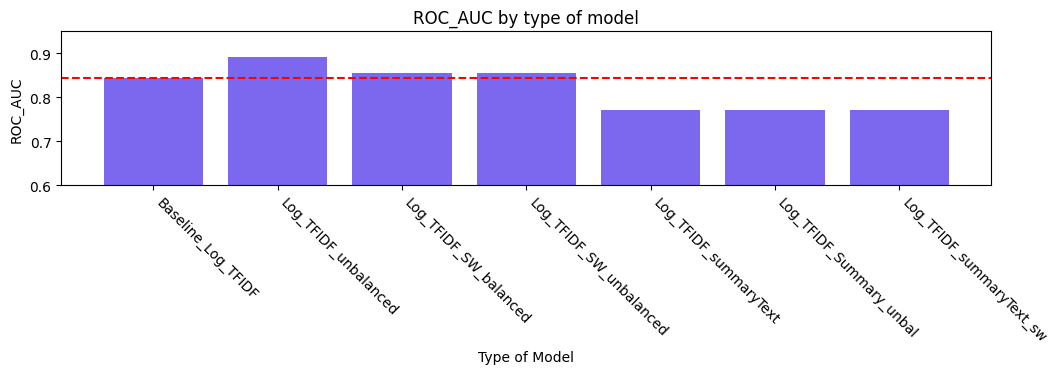

In [ ]:
fig, ax = plt.subplots(figsize=(12,2))

x = results_summary['model_name'][1:]

plt.axhline(y=results_summary['ROC_AUC'][1], color='r', linestyle='--')

ax.bar(x, results_summary['ROC_AUC'][1:], color='mediumslateblue')

ax.set_title('ROC_AUC by type of model')
ax.set_xlabel('Type of Model')
ax.set_ylabel('ROC_AUC')
plt.xticks(rotation=-45, ha="left")
ax.set_ylim([0.6, 0.95])

plt.savefig(join(dir, 'Plots/ROC_AUC_baseline.jpg'))


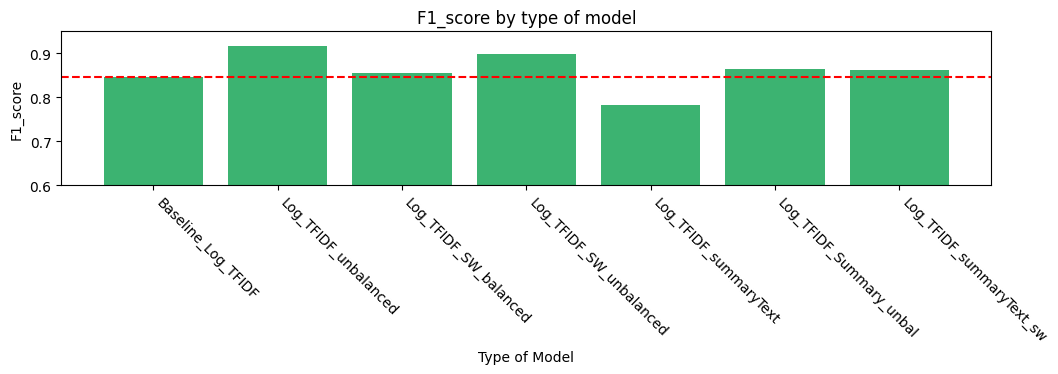

In [ ]:
fig, ax = plt.subplots(figsize=(12,2))

x = results_summary['model_name'][1:]

plt.axhline(y=results_summary['F1_score'][1], color='red', linestyle='--')

ax.bar(x, results_summary['F1_score'][1:], color='mediumseagreen')

ax.set_title('F1_score by type of model')
ax.set_xlabel('Type of Model')
ax.set_ylabel('F1_score')
ax.set_ylim([0.6, 0.95])
plt.xticks(rotation=-45, ha="left")

plt.savefig(join(dir, 'Plots/F1_score_baseline.jpg'))


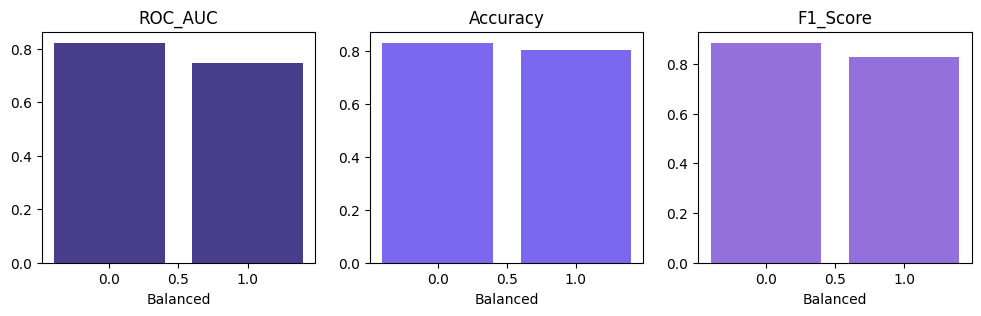

In [ ]:
balanced_df = results_summary.groupby('balanced', as_index=False)[['ROC_AUC',	'accuracy',	'F1_score']].mean()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))

# Plot the data on the axis objects
ax1.bar(balanced_df['balanced'], balanced_df['ROC_AUC'], label='ROC_AUC', color='darkslateblue')
ax2.bar(balanced_df['balanced'], balanced_df['accuracy'], label='Accuracy', color='mediumslateblue')
ax3.bar(balanced_df['balanced'], balanced_df['F1_score'], label='F1_Score', color='mediumpurple')

ax1.set_title('ROC_AUC')
ax2.set_title('Accuracy')
ax3.set_title('F1_Score')
ax1.set_xlabel('Balanced')
ax2.set_xlabel('Balanced')
ax3.set_xlabel('Balanced')

plt.show()


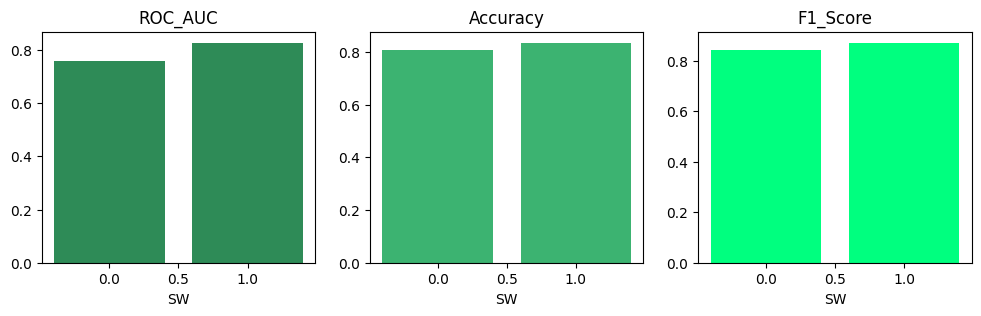

In [ ]:
sw_df = results_summary.groupby('with_sw', as_index=False)[['ROC_AUC',	'accuracy',	'F1_score']].mean()

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,3))

# Plot the data on the axis objects
ax1.bar(sw_df['with_sw'], sw_df['ROC_AUC'], label='ROC_AUC', color='seagreen')
ax2.bar(sw_df['with_sw'], sw_df['accuracy'], label='Accuracy', color='mediumseagreen')
ax3.bar(sw_df['with_sw'], sw_df['F1_score'], label='F1_Score', color='springgreen')

ax1.set_title('ROC_AUC')
ax2.set_title('Accuracy')
ax3.set_title('F1_Score')
ax1.set_xlabel('SW')
ax2.set_xlabel('SW')
ax3.set_xlabel('SW')

plt.show()